In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print "dimension de las imagenes y las clases", X.shape, y.shape

dimension de las imagenes y las clases (1500, 784) (1500,)


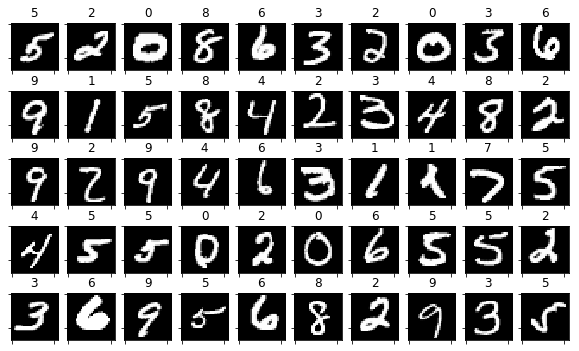

In [3]:
perm = np.random.permutation(range(X.shape[0]))[0:50]
random_imgs   = X[perm]
random_labels = y[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Autoencoder for compression

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=.2)

In [64]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.backend import clear_session

In [132]:
def get_model_A(input_dim, hidden_size, code_size):
    clear_session()
    model = Sequential()
    model.add(Dense(hidden_size, activation='relu', input_dim=input_dim))
    model.add(Dense(code_size, activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(input_dim, activation='sigmoid'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.reset_states()
    return model

porqué sigmoide en la última capa. qué pasaría si ponemos tanh o linear

In [216]:
model = get_model_A(input_dim=X.shape[1], hidden_size=256, code_size=24)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 24)                6168      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6400      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               201488    
Total params: 415,016
Trainable params: 415,016
Non-trainable params: 0
_________________________________________________________________


try with larger layer, try with more layers

In [217]:
model.fit(X_train, X_train, epochs=100, batch_size=32)

Epoch 1/100
1200/1200 [==============================] - 0s 257us/step - loss: 0.1130
Epoch 2/100
1200/1200 [==============================] - 0s 115us/step - loss: 0.0657
Epoch 3/100
1200/1200 [==============================] - 0s 118us/step - loss: 0.0528
Epoch 4/100
1200/1200 [==============================] - 0s 124us/step - loss: 0.0443
Epoch 5/100
1200/1200 [==============================] - 0s 123us/step - loss: 0.0391
Epoch 6/100
1200/1200 [==============================] - 0s 114us/step - loss: 0.0354
Epoch 7/100
1200/1200 [==============================] - 0s 113us/step - loss: 0.0322
Epoch 8/100
1200/1200 [==============================] - 0s 117us/step - loss: 0.0294
Epoch 9/100
1200/1200 [==============================] - 0s 113us/step - loss: 0.0274
Epoch 10/100
1200/1200 [==============================] - 0s 114us/step - loss: 0.0252
Epoch 11/100
1200/1200 [==============================] - 0s 115us/step - loss: 0.0236
Epoch 12/100
1200/1200 [============================

1200/1200 [==============================] - 0s 113us/step - loss: 0.0064
Epoch 96/100
1200/1200 [==============================] - 0s 111us/step - loss: 0.0064
Epoch 97/100
1200/1200 [==============================] - 0s 114us/step - loss: 0.0064
Epoch 98/100
1200/1200 [==============================] - 0s 111us/step - loss: 0.0062
Epoch 99/100
1200/1200 [==============================] - 0s 112us/step - loss: 0.0062
Epoch 100/100
1200/1200 [==============================] - 0s 111us/step - loss: 0.0061


### show reconstruction on sampled test images

In [218]:
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)

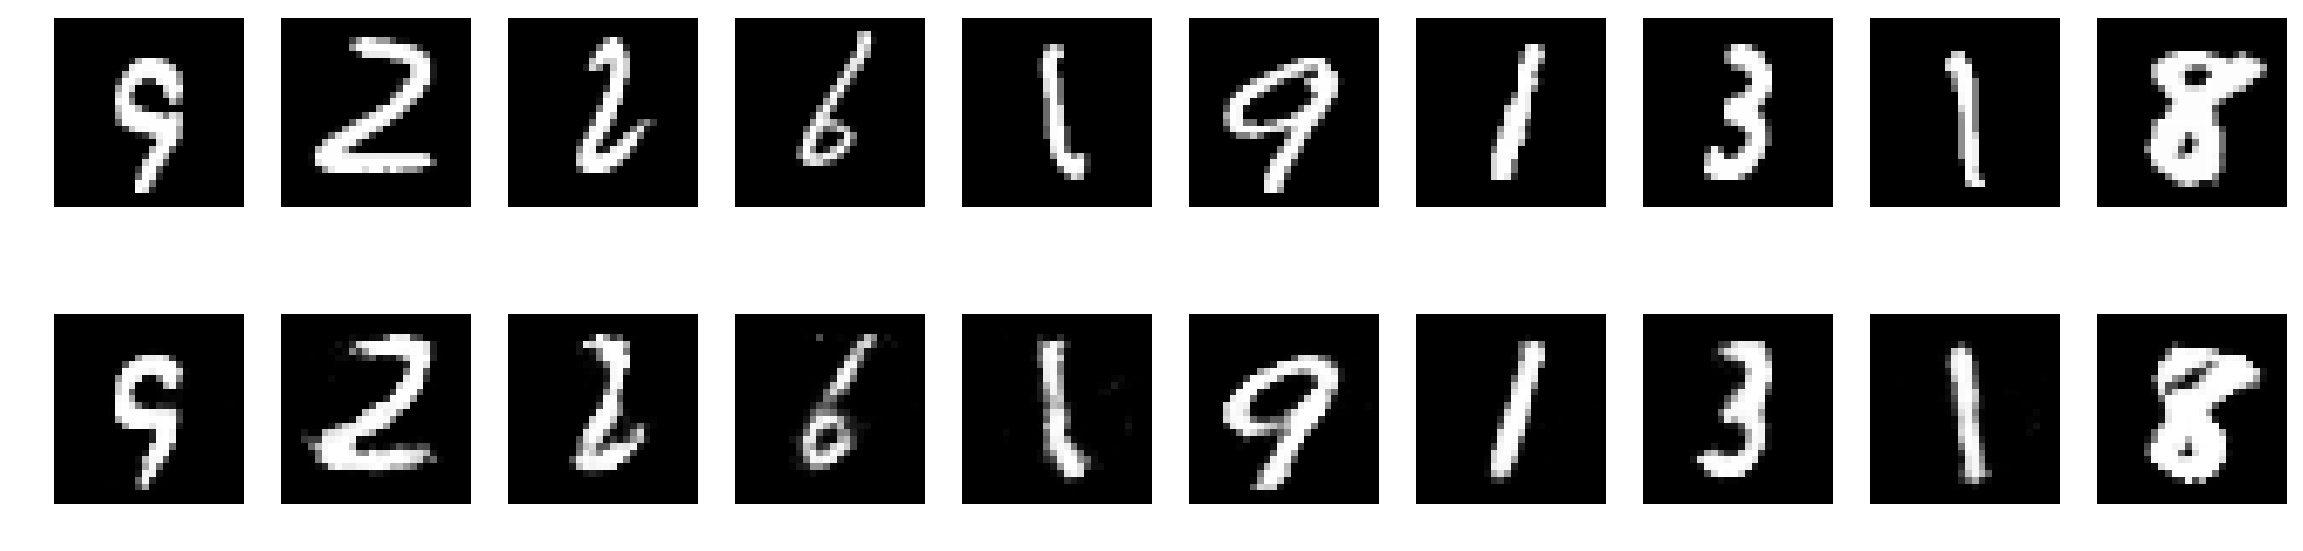

In [220]:
plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(2,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    

### show encodings

In [221]:
l1_output = K.function([model.input, K.learning_phase()], [model.layers[1].output])
X_sample_encoded = l1_output([X_sample,1.])[0]

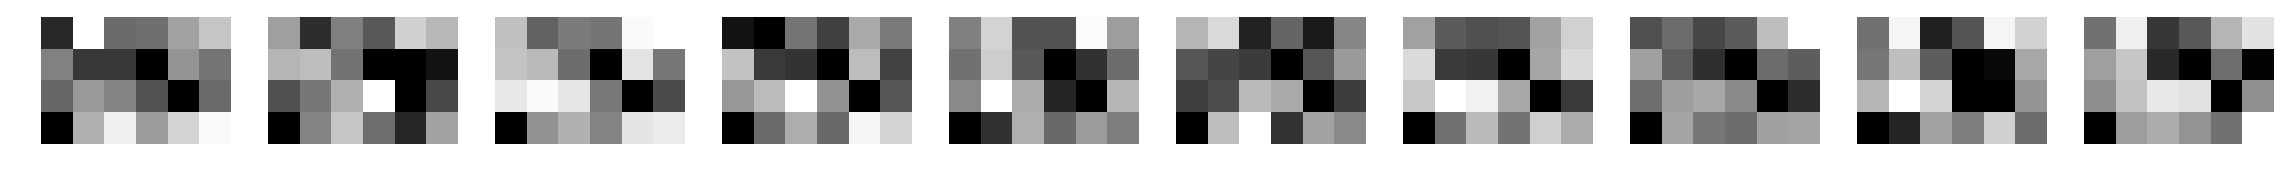

In [222]:
plt.figure(figsize=(20,2))
for i in range(len(X_sample)):
    plt.subplot(1,len(X_sample),i+1)
    plt.imshow(X_sample_encoded[i].reshape(4,-1), cmap=plt.cm.Greys_r)
    plt.axis("off")


# Autoencoder for image denoising

observe reconstruction when fed with noisy data


In [223]:
def add_noise(x, noise_level=.2):
    return x + np.random.normal(size=x.shape)*noise_level

In [224]:
X_sample_noisy = add_noise(X_sample)
X_pred_noisy   = model.predict(X_sample_noisy)

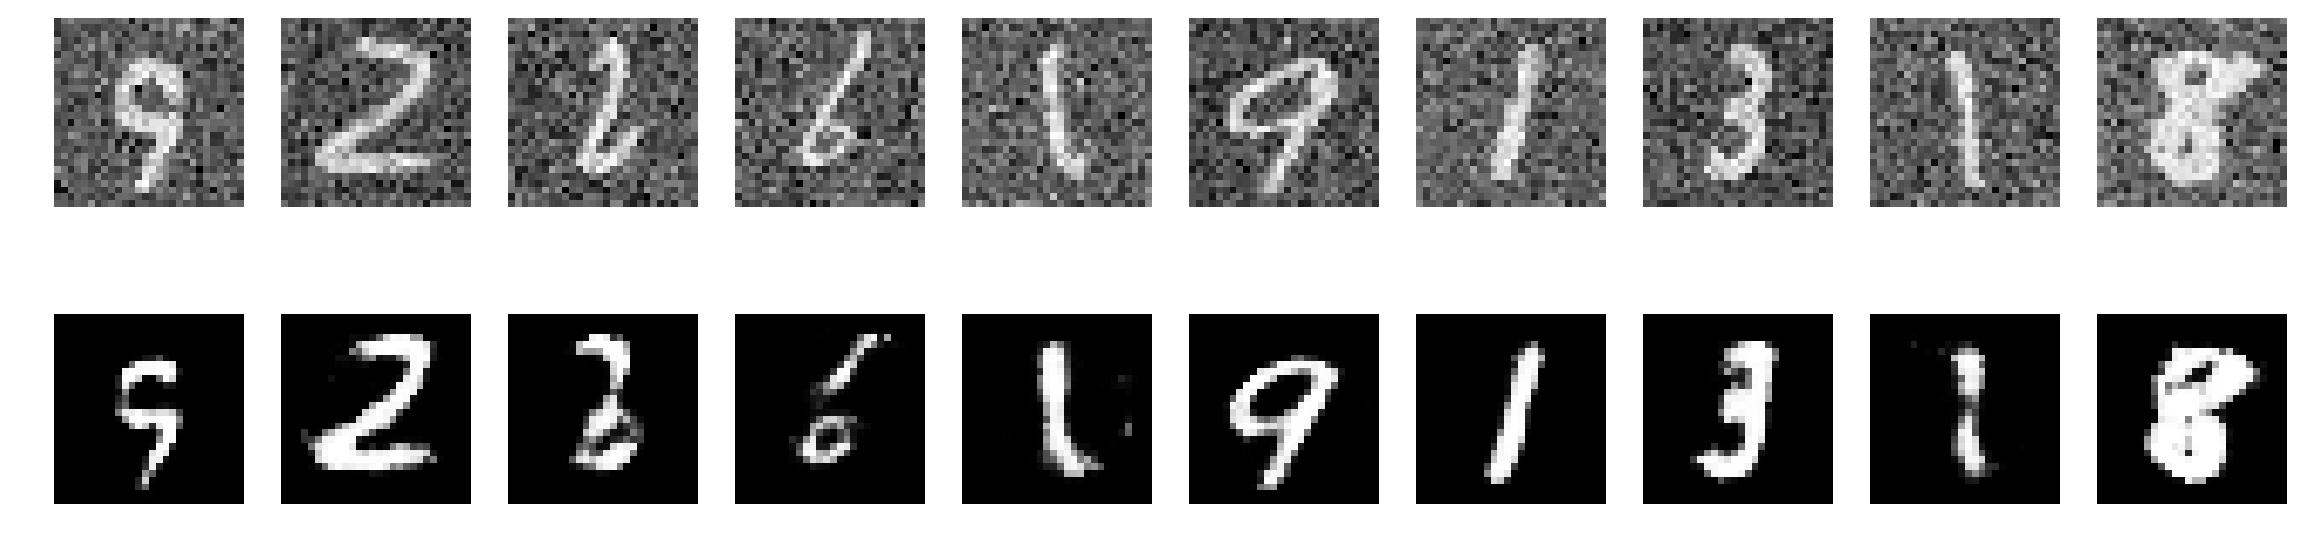

In [225]:
plt.figure(figsize=(20,5))
for i in range(len(X_sample_noisy)):
    plt.subplot(2,len(X_sample_noisy),i+1)
    plt.imshow(X_sample_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample_noisy),len(X_sample_noisy)+i+1)
    plt.imshow(X_pred_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    

but if we train with noisy data reconstruction improves



In [226]:
n_model = get_model_A(input_dim=X.shape[1], hidden_size=128, code_size=16)
X_train_noisy = add_noise(X_train)

n_model.fit(X_train_noisy, X_train, epochs=100, batch_size=32)

Epoch 1/100
1200/1200 [==============================] - 0s 200us/step - loss: 0.1241
Epoch 2/100
1200/1200 [==============================] - 0s 70us/step - loss: 0.0680
Epoch 3/100
1200/1200 [==============================] - 0s 66us/step - loss: 0.0576
Epoch 4/100
1200/1200 [==============================] - 0s 67us/step - loss: 0.0493
Epoch 5/100
1200/1200 [==============================] - 0s 66us/step - loss: 0.0435
Epoch 6/100
1200/1200 [==============================] - 0s 67us/step - loss: 0.0398
Epoch 7/100
1200/1200 [==============================] - 0s 65us/step - loss: 0.0365
Epoch 8/100
1200/1200 [==============================] - 0s 69us/step - loss: 0.0341
Epoch 9/100
1200/1200 [==============================] - 0s 65us/step - loss: 0.0323
Epoch 10/100
1200/1200 [==============================] - 0s 69us/step - loss: 0.0309
Epoch 11/100
1200/1200 [==============================] - 0s 69us/step - loss: 0.0296
Epoch 12/100
1200/1200 [==============================] - 0s 6

1200/1200 [==============================] - 0s 80us/step - loss: 0.0107
Epoch 97/100
1200/1200 [==============================] - 0s 87us/step - loss: 0.0107
Epoch 98/100
1200/1200 [==============================] - 0s 88us/step - loss: 0.0106
Epoch 99/100
1200/1200 [==============================] - 0s 63us/step - loss: 0.0105
Epoch 100/100
1200/1200 [==============================] - 0s 63us/step - loss: 0.0105


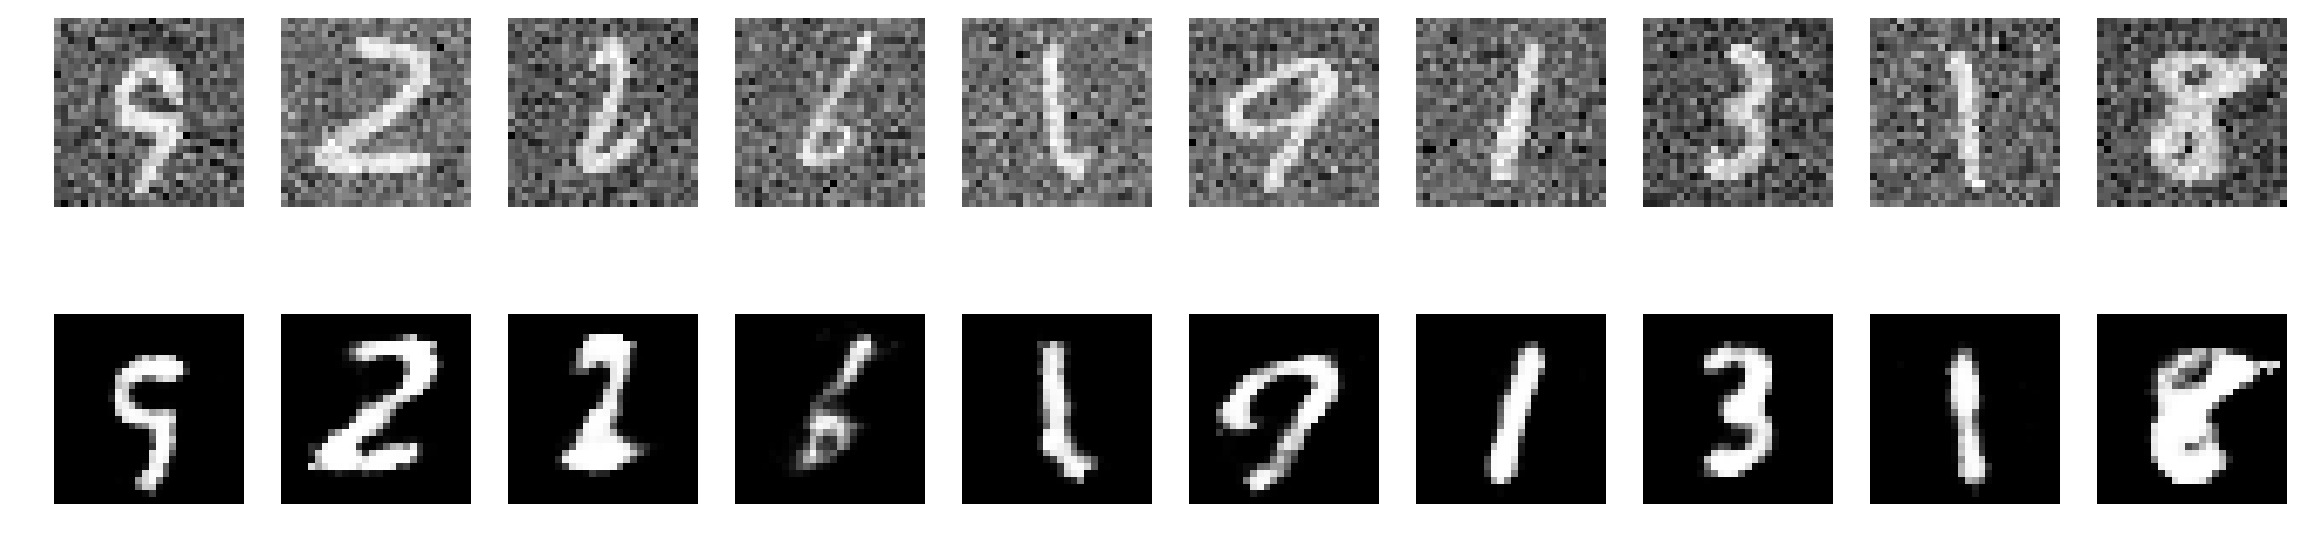

In [227]:
X_sample_noisy = add_noise(X_sample)
X_pred_noisy   = n_model.predict(X_sample_noisy)

plt.figure(figsize=(20,5))
for i in range(len(X_sample_noisy)):
    plt.subplot(2,len(X_sample_noisy),i+1)
    plt.imshow(X_sample_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample_noisy),len(X_sample_noisy)+i+1)
    plt.imshow(X_pred_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    